<h3>New York Taxi Duration Prediction</h3>

In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

#### Import and setup mlflow

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
 'Tracking/mlruns/1'), creation_time=1716367703627, experiment_id='1', last_update_time=1716367703627, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

#### Train model using Linear Regression and run manual mlflow experiment

In [7]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829445

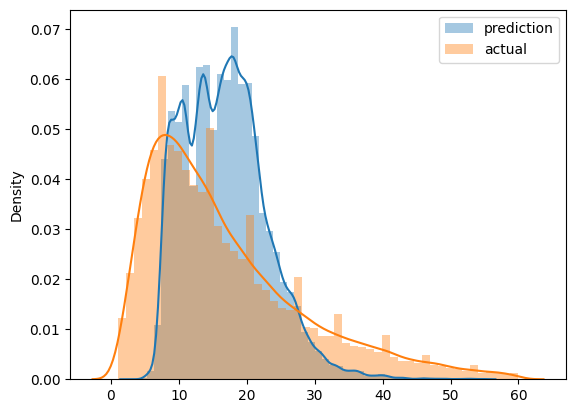

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715208946364

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [33]:
# train the model and add tracking in mlflow
with mlflow.start_run():
    mlflow.set_tag("developer", "chuks")
    mlflow.log_param("train-data-path", "'./data/green_tripdata_2021-01.parquet'")
    mlflow.log_param("valid-data-path", "'./data/green_tripdata_2021-02.parquet'")

    alpha = 0.001
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # saving the model as an artifact - method 1
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle") # log model artifact

#### Train XGBoost and manually track with hyperparameter tuning

In [22]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
# change dataset format to DMatrix as per XGBOOST required format
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:


# define objective function to use in hyperopt method fmin
def objective(params):
    with mlflow.start_run(): # tracks for each iteration
        mlflow.set_tag("model", "xgboost") # set tag
        mlflow.set_tag("developers", "chuks") 
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50,
            verbose_eval = True # show the output
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


In [25]:
# hyper parameter tuning and logging information from each iteration to mlflow
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:11.54033                          
[1]	validation-rmse:10.94143                          
[2]	validation-rmse:10.41020                          
[3]	validation-rmse:9.93963                           
[4]	validation-rmse:9.52378                           
[5]	validation-rmse:9.15784                           
[6]	validation-rmse:8.83676                           
[7]	validation-rmse:8.55565                           
[8]	validation-rmse:8.31009                           
[9]	validation-rmse:8.09611                           
[10]	validation-rmse:7.90989                          
[11]	validation-rmse:7.74825                          
[12]	validation-rmse:7.60765                          
[13]	validation-rmse:7.48574                          
[14]	validation-rmse:7.37963                          
[15]	validation-rmse:7.28774                          
[16]	validation-rmse:7.20804                          
[17]	validation-rmse:7.13889                          
[18]	valid

In [26]:
# show best result
best_result

{'learning_rate': 0.1752375182528613,
 'max_depth': 23.0,
 'min_child_weight': 1.415228552488043,
 'reg_alpha': 0.09414733746951101,
 'reg_lambda': 0.10507309746262047}

In [28]:
best_result['max_depth'] = int(best_result['max_depth'])

#### Train XGBoost and track with mlflow autolog

In [32]:
# Perform automatic logging with mlflow
params = best_result
mlflow.xgboost.autolog(silent=True) # performs automatic logging

with mlflow.start_run(): # start tracking
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
    mlflow.set_tag("model", "xgboost") # set tag
    mlflow.set_tag("developers", "chuks") # set tag
    mlflow.set_tag("logtype", "auto") # set tag
    mlflow.log_params(params)
    
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50,
        verbose_eval = False # suppress the output
    )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)    

In [35]:
# logging and saving model as an artifact
params = best_result
mlflow.xgboost.autolog(silent=True, disable=True) # disable automatic logging

with mlflow.start_run(): # start tracking
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
    mlflow.set_tag("model", "xgboost") # set tag
    mlflow.set_tag("developers", "chuks") # set tag
    mlflow.set_tag("logtype", "auto") # set tag
    mlflow.log_params(params)
    
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50,
        verbose_eval = False # suppress the output
    )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)    

    # saving the dict vectorizer as an artifact
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # save model as an artifact - method 2
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow") # log model artifact

In [36]:
# loading the model as a python function
logged_model = 'runs:/1677c63ee9ce40b0a5fd4ec1efed1572/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 1677c63ee9ce40b0a5fd4ec1efed1572

In [37]:
# loading the model using xgboost flavor
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [38]:
# making prediction
y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([14.484921,  7.237496, 15.57976 , 24.462515,  9.37887 , 17.144417,
       11.579966,  7.844187,  9.021971, 18.948055], dtype=float32)

#### Train multiple model and track with mlflow autologging

In [59]:
import shap
import numpy as np
import mlflow.sklearn
import mlflow.lightgbm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define the LightGBM regressor
LightGBMRegressor = lgb.LGBMRegressor

# List of model classes
models = [LightGBMRegressor, RandomForestRegressor, GradientBoostingRegressor]

In [60]:
# Auto log all MLflow entities
mlflow.lightgbm.autolog()

for model_class in models:
    print(f'Running model: {model_class.__name__}')
    with mlflow.start_run(): # tracks for each model

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.set_tag("model", f"{model_class.__name__}") # set tag
        mlflow.set_tag("developers", "chuks") # set tag
        mlflow.set_tag("logtype", "auto") # set tag

        # Initialize and fit the model
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        # Predict and log RMSE
        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

        # Log feature importance for LightGBM only
        if model_class == LightGBMRegressor:
            try:
                # Explain model predictions using SHAP
                explainer = shap.TreeExplainer(mlmodel)
                shap_values = explainer.shap_values(X_train, approximate = False)

                # Plot SHAP summary plot
                shap.summary_plot(shap_values, X_train, show=False, plot_type="bar", feature_names=X_train.columns)
                plt.title(f"Feature Importance - {model_class.__name__} model")
                plt.tight_layout()

                # Save plot to file and log it
                plt.savefig("feature_importance.png")
                mlflow.log_artifact("feature_importance.png")
                plt.close()
            except Exception as e:
                print(f"Failed to log feature importance plot for {model_class.__name__}: {e}")



Running model: LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 73908, number of used features: 565
[LightGBM] [Info] Start training from score 16.852578


2024/05/23 01:02:22 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "/Users/chuksokoli/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/mlflow/lightgbm/__init__.py", line 818, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "/Users/chuksokoli/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/mlflow/lightgbm/__init__.py", line 698, in log_feature_importance_plot
    fig.tight_layout()
  File "/Users/chuksokoli/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/matplotlib/figure.py", line 3538, in tight_layout
    engine.execute(self)
  File "/Users/chuksokoli/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/matplotlib/layout_engine.py", line 181, in execute
    renderer = fig._get_renderer()
  File "/Users/chuksokoli/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/matplotli

Failed to log feature importance plot for LGBMRegressor: 'csr_matrix' object has no attribute 'columns'
Running model: RandomForestRegressor
Running model: GradientBoostingRegressor
Error in callback <function _draw_all_if_interactive at 0x17953e5e0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 640x132690 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 640x132690 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x132690 with 1 Axes>

ValueError: Image size of 640x132690 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x132690 with 1 Axes>